# Интерактивное обновление параметров и пересчёт топ-кадров
Данный блок позволяет выбрать новые координаты обрезки и веса метрик, сохранить их в конфиг и обновить результаты.

In [13]:
# 2-param-selection.ipynb
import os, json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path

def show_top_frames():
    """Показать топ-3 кадра с наложенной сеткой."""
    top_files = sorted(f for f in os.listdir(top_frames_dir) if f.endswith('.jpg'))[:3]
    if not top_files:
        print("Нет топ-кадров для отображения")
        return
    fig, axes = plt.subplots(1, len(top_files), figsize=(15,5))
    for ax, fname in zip(axes, top_files):
        img = cv2.cvtColor(cv2.imread(str(top_frames_dir / fname)), cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(fname)
        h, w = img.shape[:2]
        # Сетка через 100px
        for x in range(0, w, 100): ax.axvline(x, linestyle='--', alpha=0.5)
        for y in range(0, h, 100): ax.axhline(y, linestyle='--', alpha=0.5)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


def show_metrics_plot():
    """Показать сохранённую stacked-диаграмму метрик."""
    if metrics_plot_path.exists():
        img = plt.imread(str(metrics_plot_path))
        plt.figure(figsize=(15,5))
        plt.imshow(img)
        plt.axis('off')
        plt.title("Текущее распределение метрик")
        plt.show()
    else:
        print("Диаграмма метрик не найдена!")


def update_parameters(config):
    """
    Интерактивно правит config['coordinates_pct'] и config['weights'],
    сохраняет config.json и возвращает обновлённый config.
    """
    print("\n=== Настройка процентных координат (0.0–1.0) ===")
    pct = config['coordinates_pct']
    for k in ('x1','y1','x2','y2'):
        pct[k] = float(input(f"{k} (текущий: {pct[k]}): ") or pct[k])

    print("\n=== Настройка весов метрик ===")
    w = config['weights']
    for k in ('WEIGHT_TEXT','WEIGHT_DIFF','WEIGHT_SIMILARITY','WEIGHT_RECENCY'):
        w[k] = float(input(f"{k} (текущий: {w[k]}): ") or w[k])

    with open(config_path, 'w', encoding='utf-8') as f:
        json.dump(config, f, ensure_ascii=False, indent=4)
    print(f"[INFO] Обновлён {config_path}")
    return config


def frame_diff(frame1, frame2):
    """Нормализованный diff между двумя кадрами."""
    if frame1 is None or frame2 is None:
        return 0.0
    g1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    g2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    return float(np.sum(cv2.absdiff(g1, g2))) / g1.size


def recalculate_metrics(config):
    """
    Пересчитывает diff_score по новым coords_pct и нормализует три метрики.
    Ожидает, что all_frames_data.json содержит записи с полями:
      - filename
      - timecode
      - text_qty
      - diff_score
      - sim_score
      - rec_norm
    Возвращает список тех же записей, но с добавленными полями:
      - text_n, diff_n, sim_n, rec_norm (если его не было).
    """
    import cv2, numpy as np, json
    from pathlib import Path

    # Загружаем данные
    with open(all_frames_data, 'r', encoding='utf-8') as f:
        frames = json.load(f)

    pct = config['coordinates_pct']
    prev_crop = None

    # 1) Пересчёт diff_score
    for rec in frames:
        img = cv2.imread(str(all_frames_dir / rec['filename']))
        if img is None:
            rec['diff_score'] = 0.0
            continue
        h, w = img.shape[:2]
        x1 = int(pct['x1'] * w);  y1 = int(pct['y1'] * h)
        x2 = int(pct['x2'] * w);  y2 = int(pct['y2'] * h)
        crop = img[y1:y2, x1:x2]
        rec['diff_score'] = float(frame_diff(crop, prev_crop))
        prev_crop = crop

    # 2) Нормализация text_qty, diff_score, sim_score
    def normalize(arr):
        a = np.array(arr, float)
        return (a - a.min())/(a.max() - a.min()) if a.max()>a.min() else np.ones_like(a)

    texts =   [r['text_qty']   for r in frames]
    diffs =   [r['diff_score'] for r in frames]
    sims  =   [r['sim_score']  for r in frames]

    norm_text = normalize(texts)
    norm_diff = normalize(diffs)
    norm_sim  = normalize(sims)

    for i, r in enumerate(frames):
        r['text_n'] = float(norm_text[i])
        r['diff_n'] = float(norm_diff[i])
        r['sim_n']  = float(norm_sim[i])
        # rec_norm уже есть из первого ноутбука, но если нет — встанет 0
        r['rec_norm'] = float(r.get('rec_norm', 0.0))

    return frames

def plot_updated_metrics(frames, config):
    """
    Рисует stacked-бар по нормализованным метрикам и весам.
    Берёт:
      - timecode
      - text_n, diff_n, sim_n, rec_norm
    """
    import matplotlib.pyplot as plt
    import numpy as np

    times = [r['timecode'] for r in frames]
    if len(times) > 1:
        w = (times[1] - times[0]) * 0.8
    else:
        w = 1.0

    bottom = np.zeros(len(frames))
    plt.figure(figsize=(15,7))

    comps = [
      (config['weights']['WEIGHT_TEXT'],      [r['text_n']   for r in frames], 'Text'),
      (config['weights']['WEIGHT_DIFF'],      [r['diff_n']   for r in frames], 'Diff'),
      (config['weights']['WEIGHT_SIMILARITY'],[r['sim_n']    for r in frames], 'Sim'),
      (config['weights']['WEIGHT_RECENCY'],   [r['rec_norm'] for r in frames], 'Recency'),
    ]

    for weight, vals, label in comps:
        arr = np.array(vals) * weight
        plt.bar(times, arr, width=w, bottom=bottom, label=label)
        bottom += arr

    plt.title("Обновленные составные метрики")
    plt.xlabel("Время (с)")
    plt.ylabel("Оценка")
    plt.legend(); plt.grid(True)
    plt.savefig(str(metrics_plot_path))
    plt.show()



def remove_directory_contents(directory):
    """Удалить всё внутри directory, оставив саму папку."""
    if not os.path.exists(directory):
        return
    for root, dirs, files in os.walk(directory, topdown=False):
        for name in files:
            os.remove(os.path.join(root, name))
        for name in dirs:
            os.rmdir(os.path.join(root, name))


def update_top_frames(frames, config, top_n, top_frames_dir, all_frames_dir):
    """
    Обновляет топ-кадры по composite score.
    Берёт из frames поля:
      - timecode, text_n, diff_n, sim_n, rec_norm, filename
    И сохраняет:
      - <6digit>s_top_<i>.jpg
      - top_frames_data.json
    """
    import os, json, cv2
    import numpy as np
    from pathlib import Path

    # 1) Очистка
    remove_directory_contents(str(top_frames_dir))
    os.makedirs(top_frames_dir, exist_ok=True)

    # 2) Сортировка
    def comp(r):
        return (
            r['text_n'] * config['weights']['WEIGHT_TEXT'] +
            r['diff_n'] * config['weights']['WEIGHT_DIFF'] +
            r['sim_n']  * config['weights']['WEIGHT_SIMILARITY'] +
            r['rec_norm'] * config['weights']['WEIGHT_RECENCY']
        )
    top = sorted(frames, key=comp, reverse=True)[:top_n]

    # 3) Сохранение
    new_data = []
    for idx, r in enumerate(top, start=1):
        img = cv2.imread(str(Path(all_frames_dir) / r['filename']))
        h, w = img.shape[:2]
        pct = config['coordinates_pct']
        x1 = int(pct['x1']*w); y1 = int(pct['y1']*h)
        x2 = int(pct['x2']*w); y2 = int(pct['y2']*h)
        crop = img[y1:y2, x1:x2]
        fname = f"{int(round(r['timecode'])):06d}s_top_{idx}.jpg"
        out = str(Path(top_frames_dir) / fname)
        ok = cv2.imwrite(out, crop)
        if not ok:
            print(f"[WARN] cv2.imwrite failed: {out}")
        rec = r.copy(); rec['filename'] = fname
        new_data.append(rec)

    # 4) Отчёт
    with open(str(Path(top_frames_dir) / "top_frames_data.json"), 'w', encoding='utf-8') as f:
        json.dump(new_data, f, ensure_ascii=False, indent=4)

    print(f"[INFO] Обновлён top_frames_data.json в {top_frames_dir}")

In [14]:

# config.json лежит рядом с этим ноутбуком
notebook_dir = Path().resolve()
config_path  = notebook_dir / "config.json"

def load_config():
    if config_path.exists():
        with open(config_path, "r", encoding="utf-8") as f:
            return json.load(f)
    # если нет — создаём в том же формате, что и в первом ноутбуке
    default = {
      "base_directory": str(notebook_dir),
      "number_video_images": 10,
      "weights": {
        "WEIGHT_TEXT":       0.1,
        "WEIGHT_DIFF":       0.6,
        "WEIGHT_SIMILARITY": 0.2,
        "WEIGHT_RECENCY":    0.05
      },
      "coordinates_pct": {
        "x1": 0.0, "y1": 0.0,
        "x2": 1.0, "y2": 1.0
      }
    }
    with open(config_path, "w", encoding="utf-8") as f:
        json.dump(default, f, ensure_ascii=False, indent=4)
    return default


cfg = load_config()
BASE_DIR   = Path(cfg["base_directory"])
coords_pct = cfg["coordinates_pct"]
weights    = cfg["weights"]
NUM_IMG    = cfg["number_video_images"]


In [15]:
# 2) Укажите, с каким видео/папкой работаем
VIDEO_NAME = input(f"Введите имя папки с кадрами в папке output/images (название видео): ").strip()
if not VIDEO_NAME:
    raise ValueError("Нужно указать имя папки с результатами работы первого ноутбука.")

# 3) Пути к данным первого ноутбука
all_frames_dir    = BASE_DIR / "work"   / "all_images" / VIDEO_NAME
top_frames_dir    = BASE_DIR / "output" / "images"     / VIDEO_NAME

metrics_plot_path = all_frames_dir / "composite_score_components.png"
all_frames_data   = all_frames_dir / "all_frames_data.json"
top_frames_data   = top_frames_dir / "top_frames_data.json"

# создаём папки, если ещё нет
os.makedirs(all_frames_dir, exist_ok=True)
os.makedirs(top_frames_dir, exist_ok=True)


Введите имя папки с кадрами (топ-5):  WEEK_3_-_LEC_14


=== Предварительный просмотр ===


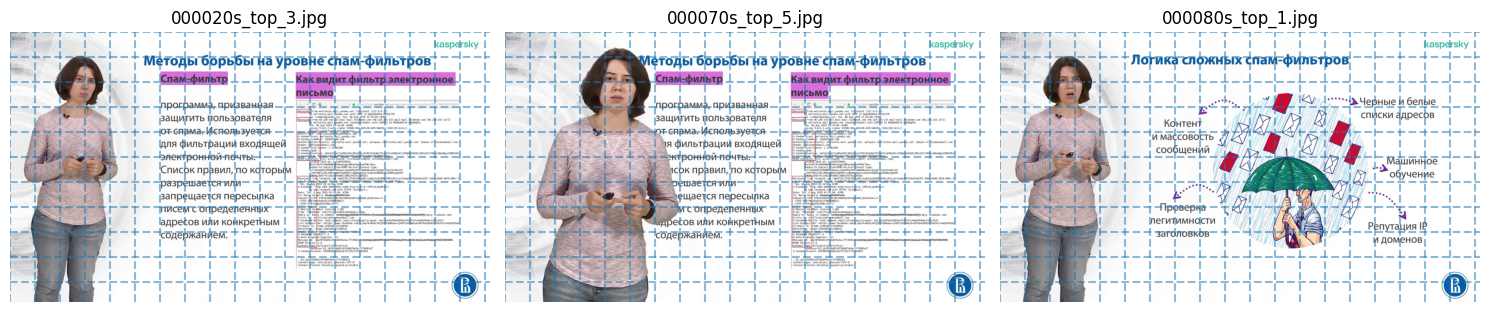

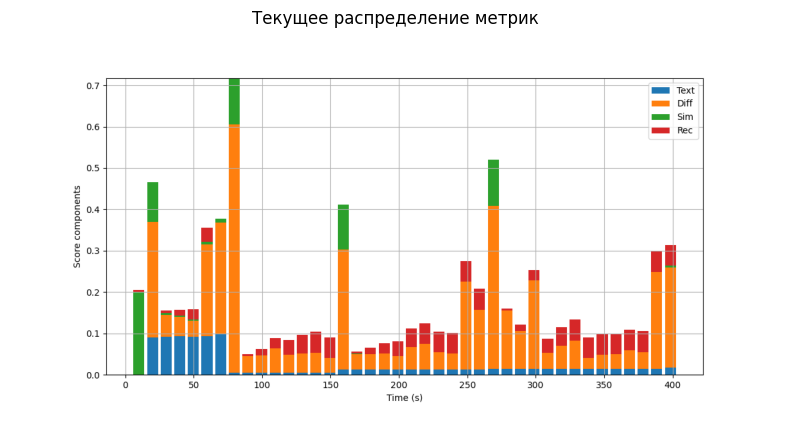

In [16]:
print("=== Предварительный просмотр ===")
show_top_frames()
show_metrics_plot()


In [17]:
# 6) Интерактивное редактирование config.json
cfg = update_parameters(cfg)



=== Настройка процентных координат (0.0–1.0) ===


x1 (текущий: 0.3):  0.3
y1 (текущий: 0.5):  0.5
x2 (текущий: 0.9):  0.9
y2 (текущий: 0.9):  0.9



=== Настройка весов метрик ===


WEIGHT_TEXT (текущий: 0.1):  0.1
WEIGHT_DIFF (текущий: 0.55):  0.55
WEIGHT_SIMILARITY (текущий: 0.3):  0.3
WEIGHT_RECENCY (текущий: 0.05):  0.05


[INFO] Обновлён /home/jupyter/work/resources/config.json



=== Пересчёт метрик ===


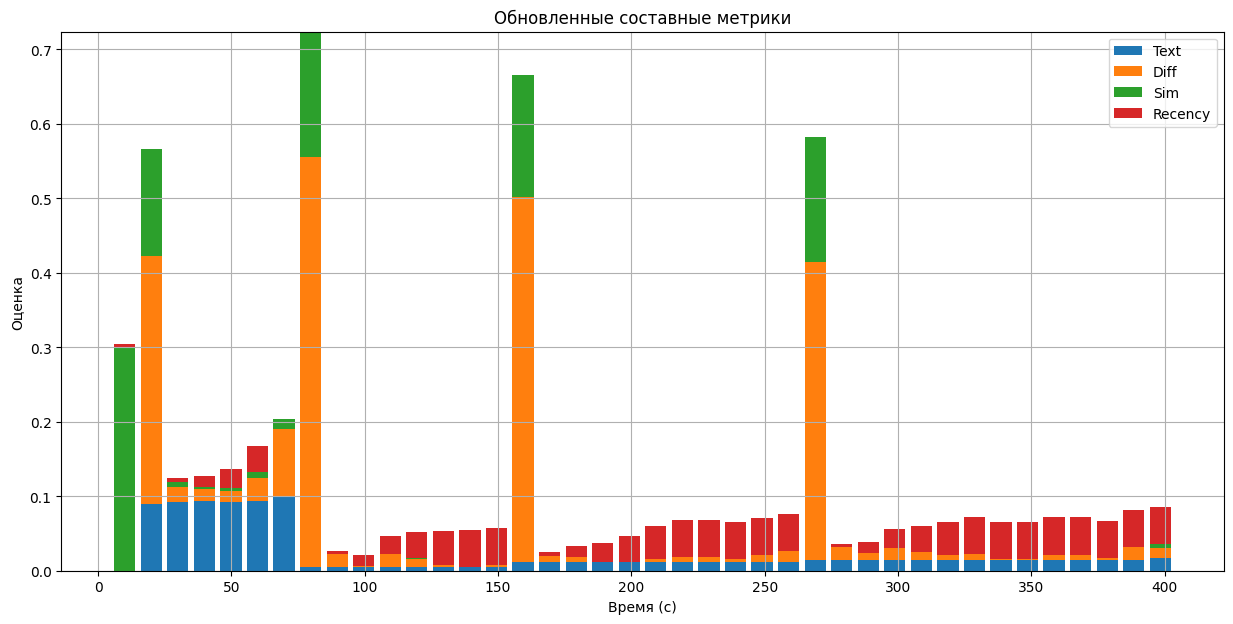

In [18]:
# 7) Пересчёт метрик и отрисовка новой диаграммы
print("\n=== Пересчёт метрик ===")
frames = recalculate_metrics(cfg)
plot_updated_metrics(frames, cfg)

In [19]:
# 8) Обновление топ-N кадров
top_n = int(input(f"\nСколько ключевых кадров оставить? [по умолчанию {NUM_IMG}]: ") or NUM_IMG)
update_top_frames(frames, cfg, top_n, top_frames_dir, all_frames_dir)

# 9) Итог
print("\n=== Готово! ===")
print(f"Новые топ-{top_n} кадра в папке: {top_frames_dir}")
print(f"Обновлённая диаграмма:      {metrics_plot_path}")
print(f"Единый config:             {config_path}")


Сколько ключевых кадров оставить? [по умолчанию 5]:  4


[INFO] Обновлён top_frames_data.json в /home/jupyter/datasphere/s3/transcribation-project/test/output/images/WEEK_3_-_LEC_14

=== Готово! ===
Новые топ-4 кадра в папке: /home/jupyter/datasphere/s3/transcribation-project/test/output/images/WEEK_3_-_LEC_14
Обновлённая диаграмма:      /home/jupyter/datasphere/s3/transcribation-project/test/work/all_images/WEEK_3_-_LEC_14/composite_score_components.png
Единый config:             /home/jupyter/work/resources/config.json
